In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from pyens.models import Flywheel, OCV, EcmCell
from pyens.utilities import ivp
from pyens.simulations import Data, Current, Learner,Simulator
import os
import matplotlib.pyplot as plt

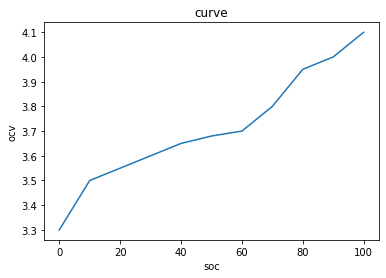

In [2]:
ocv = [3.3, 3.5, 3.55, 3.6, 3.65, 3.68, 3.70, 3.8, 3.95, 4.0, 4.1]
soc = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

In [3]:
param = {
 "R0": 0.034,
 "R1": 0.022,
 "C1": 1500,
 "R2": 0.019,
 "C2": 65000,
 "CAP": 15,
 "ce": 0.96,
 "v_limits": [2.5, 4.5],
 "SOC_RANGE": [0.0, 100.0],
}

m1 = EcmCell(name="cell_model1", parameters=param, curve=c1)
# m1.display()

In [4]:
dt = 0.1
CURR_EXCITATION = 7.5
HOUR = 3600.0
h_steps = [1.75, 0.25, 0.25, 0.25, 1, 1, 1]
current_steps = [
 -CURR_EXCITATION,
 -CURR_EXCITATION / 2,
 -CURR_EXCITATION / 4,
 -CURR_EXCITATION / 8,
 0.0,
 CURR_EXCITATION,
 0.0,
]

initial_soc = 0.0
t_steps = [value * HOUR for value in h_steps]
total_time = sum(t_steps)
samples = int(total_time / dt)

time_np = np.linspace(0.0, total_time, samples)
step_cur = Current(name="current1")

In [5]:
for t_step, current_step in zip(t_steps, current_steps):
 step_cur.add_step(current_step, int(t_step / dt))

data = {"time": time_np, "current": step_cur.current}
df = pd.DataFrame(data)
d1 = Data(name="current_excite", df=df)

In [6]:
s1 = Simulator(name="simulator1")
s1.attach(m1).attach(d1)

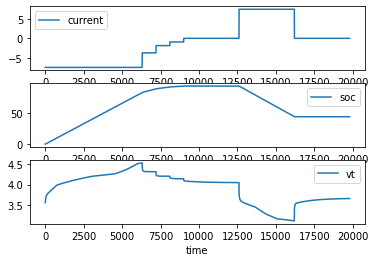

In [7]:
sol = s1.run(
    pair=("cell_model1", "current_excite"),
    x0=np.array([0, 0, initial_soc]),
    config={"solver_type": "adaptive", "solution_name": "sol1"},
)

sol.disp(["current", "soc", "vt"])

In [8]:
TESTDATA_FILEPATH = os.path.join(os.path.dirname(os.getcwd()),'tests/CS2_3_9_28_11.csv')
schema = {
    "Test_Time(s)": "time",
    "Current(A)": "current",
    "Voltage(V)": "vt",
    "rsv_i_dir": True,
}
d1 = Data(name='d1', df=None)
d1.fetch_file(TESTDATA_FILEPATH, schema=schema)
# save the calculation time
# d1.df=d1.df[d1.df['time']>3000].reset_index()

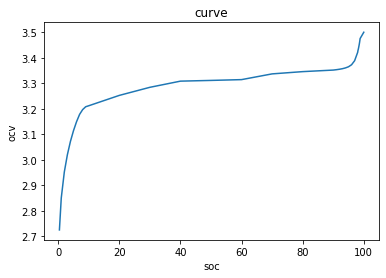

In [4]:
TESTDATA_FILEPATH = os.path.join(os.path.dirname(os.getcwd()),'tests/CALCE_A123_007.csv')

schema = {
    "Time": "time",
    "max_current": "current",
    "max_v_tr": "vt",
    "rsv_i_dir": False,
}
d1 = Data(name="d1", df=None)
d1.fetch_file(TESTDATA_FILEPATH, schema=schema)
d1.to_abs_time()

ocv = [
    2.725578,
    2.850545,
    2.952456,
    3.020007,
    3.072155,
    3.114243,
    3.149442,
    3.178211,
    3.196915,
    3.208162,
    3.21203,
    3.252616,
    3.284272,
    3.308415,
    3.311269,
    3.314391,
    3.336869,
    3.345692,
    3.351787,
    3.353211,
    3.354968,
    3.357175,
    3.360247,
    3.364758,
    3.372647,
    3.388452,
    3.421374,
    3.428617,
    3.433137,
    3.438826,
    3.444884,
    3.4514,
    3.458486,
    3.466429,
    3.475249,
    3.5,
]
soc = [
    0.397351,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    98.1,
    98.2,
    98.3,
    98.4,
    98.5,
    98.6,
    98.7,
    98.8,
    100.0,
]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

In [6]:
param_sim = {
    "R0": 0.034,
    "R1": 0.022,
    "C1": 1500,
    "R2": 0.019,
    "C2": 65000,
    "CAP": 1.1,
    "ce": 0.99,
    "v_limits": [1.5, 4.5],
    "SOC_RANGE": [0.0, 100.0],
}
m_sim = EcmCell(name="cell_model_sim", parameters=param_sim, curve=c1)
l2 = Learner(name="l2")
l2.attach(d1).attach(m_sim)
x0_sim = np.array([0, 0, 100])
config = {"solver_type": "adaptive", "solution_name": "sol1"}
method = "minimize"
res = l2.fit_parameters(("cell_model_sim", "d1"), config, x0_sim, method)

/workspaces/pyens/pyens/simulations/learns.py:54: OptimizeWarning: Unknown solver options: xatol, fatol
  res = minimize(


rmse 0.10547099142516307 2754 2754
rmse 0.10411243058779499 2754 2754
rmse 0.10303489196870878 2754 2754
rmse 0.10242494781753855 2754 2754
rmse 0.10206979701003015 2754 2754
rmse 0.1018587296077003 2754 2754
rmse 0.10173152371656062 2754 2754
rmse 0.10165414911756765 2754 2754
rmse 0.10160680492958764 2754 2754
rmse 0.10157772668142759 2754 2754
rmse 0.10155982494448286 2754 2754
rmse 0.10154878766594971 2754 2754
rmse 0.10154197641782686 2754 2754
rmse 0.1015377707185675 2754 2754
rmse 0.10153517293707558 2754 2754
rmse 0.1015335679865488 2754 2754
rmse 0.10153257628905579 2754 2754
rmse 0.10153196346899032 2754 2754
rmse 0.10153157002525655 2754 2754
rmse 0.160631380639541 2754 2754
rmse 0.24040468753283567 2754 2754
rmse 0.12217966498913028 2754 2754
rmse 0.10164457405797449 2754 2754
rmse 0.0988733128890882 2754 2754
rmse 0.09568071498921107 2754 2754
rmse 0.0986581359177066 2754 2754
rmse 0.099767866028338 2754 2754
rmse 0.09770471606426538 2754 2754
rmse 0.09879530032547192 2754

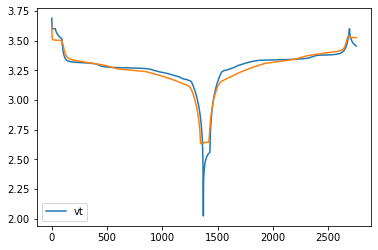

In [7]:
param_exr = {
    "R0": res.x[0],
    "R1": res.x[1],
    "C1": res.x[2],
    "R2": res.x[3],
    "C2": res.x[4],
    "CAP": res.x[5],
    "ce": 0.99,
    "v_limits": [1.5, 4.5],
    "SOC_RANGE": [0.0, 100.0],
}

m_exr = EcmCell(name="cell_model_exr", parameters=param_exr, curve=c1)
s3 = Simulator(name="s3")
s3.attach(d1).attach(m_exr)
d3 = s3.run(("cell_model_exr", "d1"), x0_sim)
ax = d1.df[["vt"]].plot()
d3.df["vt"].plot(ax=ax)
plt.show()